# Heart Failure Prediction

Kaggle excerpt:

>Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
    Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

>Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

>People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.


Data Source: https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data

Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020). Available at: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5

## Dataset original features:
    - age: Age
    - anaemia: Decrease of red blood cells or hemoglobin (boolean - 0 = No, 1 = Yes)
    - creatinine_phosphokinase: Level of the CPK enzyme in the blood (mcg/L)
    - diabetes: If the patient has diabetes (boolean - 0 = No, 1 = Yes)
    - ejection_fraction: Percentage of blood leaving the heart at each contraction (percentage)
    - high_blood_pressure: If the patient has hypertension (boolean - 0 = No, 1 = Yes)
    - platelets: Platelets in the blood (kiloplatelets/mL)
    - serum_creatinine: Level of serum creatinine in the blood (mg/dL)
    - serum_sodium: Level of serum sodium in the blood (mEq/L)
    - sex: Woman or man (binary - Male = 1, Female =0)
    - smoking: 0 = No, 1 = Yes
    - time: captures the time of the event. That is, the time at which the patient died or were censored.
    - DEATH_EVENT: encodes whether the patient died (1) or whether they were censored (0). Censoring means that the scientists lost contact with the patient.
        
Features descriptions gathered from kaggle "About this dataset" and "Discussion" sections        

## Importing Packages

In [1]:
import os

import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from seaborn_qqplot import pplot
from scipy.stats import norm

from scipy.stats import kstest
import researchpy as rp
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import f_oneway



from IPython.core.display import display, HTML

## User Defined Functions

In [2]:
def chck_miss(df):
    '''Checking dataset for missing values distribution'''

    Total = df.isnull().count().sort_values(ascending=True)        
    Missing = df.isnull().sum().sort_values(ascending=True)   

    Percentage_Miss = round((Missing/Total)*100,2)

    Summary = pd.concat([Total,Missing, Percentage_Miss],axis=1,keys=['Total','# Missing','% Missing'],sort=True)
          
    print('Are there any missing value?')                    
    print(Summary)         

    del Total, Missing, Percentage_Miss, Summary 

In [3]:
def check_level(df):
    '''Checking dataset categorical features levels'''
    print("Checking the categories levels of categorical features: \n")
    for i in df.columns:
        if (df[i].dtype == object):
            print('These are the categories of \'',i,' \':\n',df[i].unique(), '\n')
    del i 
    

In [4]:
def check_duplicates(df,maintain='last'):
    '''Checking duplicate values in dataset'''
    
    res = df.duplicated().sum()
    print('There are', res , 'duplicated values in dataset.' )
    if res != 0 :
        df.drop_duplicates(keep = maintain,inplace=True)
        if maintain == 'last':
            print('Duplicated values were dropped maintaning only the last occurrence')
        else:
             print('Duplicated values were dropped maintaning only the first occurrence')

In [5]:
def uni_categorical(df,# data frame, if variable inform as df[[var]]
                    size=None,# size of the plot to be create: "L" large,otherwise Small
                    label=None, #if the bar plot should have labels and ticks
                    ref=None, # ref add a y-axis reference line inform value
                   ):
    '''This function returns summarization and visual for univariate analysis of categorical features of a dataset'''
    print('############### Univariate analysis - Categorical ###############')
# Setting canvas  
    sns.color_palette("dark")    #, as_cmap=True
    sns.set_context("talk", font_scale=0.8) #paper, notebook, talk, poster

    #extracting only non-numerical features
    df = df.select_dtypes(exclude=np.number) 
    for i in df.columns:
     #   if type(df.loc[0, i]) == str: #checking type of features
# Summarization
            d1 = df[i].value_counts(dropna=False)
            d2 = round(df[i].value_counts(normalize=True,dropna=False)*100, 2)
            d3 = pd.concat([d1, d2], axis=1)
            d3.columns = ['Count', 'Percentage']
            print('\nThis is univariate analysis for', "'", i, "'", '\n', d3)

 # Visualization
            d1 = pd.DataFrame(d1).T
            d1 = pd.melt(d1,var_name=str(i),value_vars=d1) 
            d1[i]=d1[i].fillna('Missing') 
            fig, ax = plt.subplots()
            if size == 'L':
                fig.set_size_inches(22, 10)
            else:
                fig.set_size_inches(8, 8)
            plot1=sns.barplot(y=d1['value'],x=d1[i], data=d1)#,color='darkblue'
            if label == 'Y':
                for p in ax.patches:
                    ax.annotate(int(p.get_height()), 
                    (p.get_x()+p.get_width()/2+.3, p.get_height()),        
                    ha='center',va='center',xytext=(2, 10),textcoords='offset points', rotation=45)
            else:
                plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected,'major', 'minor', 'both'
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
            plt.xticks(rotation=45, ha='right') 
            if ref != None:
                plot1.axhline(ref,c='red',label='threshold='+str(ref),linestyle='--')
                plt.legend(loc=1)
            ax.set_title('Univariate plot')
            plt.show()
    print('\n\n')

In [6]:
def uni_numerical(df):
    '''This function returns summarization and visual for univariate analysis of numerical features of a dataset'''
    
# Setting canvas  
    sns.color_palette("dark")    #, as_cmap=True
    sns.set_context("talk", font_scale=1) #paper, notebook, talk, poster
    
# Summarization
    print('############### Univariate analysis - Numerical ###############**')
    df.describe()
    Summary = dict(df.describe())
    for i in Summary:
        Summary[i]['count'] = df[i].count()
        Summary[i]['variance'] = df[i].var()
        Summary[i]['IQR'] = Summary[i]['75%'] - Summary[i]['25%']
        Summary[i]['range'] = Summary[i]['max'] - Summary[i]['min']
        Summary[i]['skewness'] = df[i].skew()
        Summary[i]['kurtosis'] = df[i].kurtosis()
        Summary[i]['mode'] = df[i].mode() #axis='columns'
#    print(Summary)
        print('\n This is univariate analysis for',"'", i, "'", '\n', Summary[i])
# Visualization
        # Histogram and Boxplot
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.12, .88)})
        f.set_size_inches(10, 6.5)
#         sns.distplot(a=df[i], hist=True, kde=True, rug=True, ax=ax_hist)
        sns.histplot(x=df[i], kde=True, ax=ax_hist)
        sns.boxplot(x=df[i], ax=ax_box)
        ax_box.set_title('Univariate plot')
        ax_box.set(xlabel='')
        plt.show()
        #Q-Q plot
     
        pplot(df, x=i, y=norm, kind='qq',height=8,display_kws={"identity":True})
        plt.title("QQ Plot")
        plt.show()
# normality test
#        stat, p_normal = shapiro(df[i])
        stat, p_normal = kstest(df[i],'norm')    
        print('Kolmogorov\'s Statistics=%.3f, p=%.3f' % (stat, p_normal))
# interpretation
        alpha = 0.05
        if p_normal > alpha:
            print('Normality\'s test result: Sample looks Gaussian (fail to reject H0)\n\n')
        else:
            print('Normality\'s test result: Sample does not look Gaussian (reject H0)\n\n')
        print('_____________________________________________________________________________\n\n')

#### Setting cell size for better visualization

In [7]:
display(HTML("<style>div.output_scroll { height: 99em; }</style>"))

### Setting warnings OFF/ON

In [8]:
warnings.filterwarnings('always')#'ignore'

## Loading Dataset

In [9]:
# Changing Directory
os.chdir(r'D:\Cursos\Repositories\Heart_Failure_Prediction\Data\Raw Data\archive')

df = pd.read_csv('heart_failure_clinical_records_dataset.csv',dtype={'anaemia':str, 
                                                                     'diabetes':str, 
                                                                     'high_blood_pressure':str, 
                                                                     'sex':str,
                                                                     'smoking':str, 
                                                                     'DEATH_EVENT':str})

First look at dataset:

In [10]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [11]:
print('Shape of dataset: ',df.shape)

Shape of dataset:  (299, 13)


In [12]:
print('Features types:\n ',df.dtypes) 

Features types:
  age                         float64
anaemia                      object
creatinine_phosphokinase      int64
diabetes                     object
ejection_fraction             int64
high_blood_pressure          object
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                          object
smoking                      object
time                          int64
DEATH_EVENT                  object
dtype: object


Checking for missing values:

## Splitting Data set

Setting target and dividing training and test datasets:

In [13]:
target='DEATH_EVENT'

# Creating copy of df for exploration data analysis:
df_exp = df.copy()

X = df_exp.drop([target],axis=1)
y = df_exp[target]

# Dividing into training and test datasets:

X_train, X_test,y_train,y_test = train_test_split(X,y,random_state=8,test_size=0.3)

# Merging X and y to perform exploratory data analysis

df_exp = pd.concat([X_train, y_train], axis=1, join='inner')

## Exploratory Data Analysis
### Checking categorical features

Exploratory data analysis will be performed only on train data to get the most unbiased estimate

In [14]:
chck_miss(df_exp)

Are there any missing value?
                          Total  # Missing  % Missing
DEATH_EVENT                 209          0        0.0
age                         209          0        0.0
anaemia                     209          0        0.0
creatinine_phosphokinase    209          0        0.0
diabetes                    209          0        0.0
ejection_fraction           209          0        0.0
high_blood_pressure         209          0        0.0
platelets                   209          0        0.0
serum_creatinine            209          0        0.0
serum_sodium                209          0        0.0
sex                         209          0        0.0
smoking                     209          0        0.0
time                        209          0        0.0


There are no missing values in this dataset.

In [15]:
check_level(df_exp)

Checking the categories levels of categorical features: 

These are the categories of ' anaemia  ':
 ['0' '1'] 

These are the categories of ' diabetes  ':
 ['1' '0'] 

These are the categories of ' high_blood_pressure  ':
 ['0' '1'] 

These are the categories of ' sex  ':
 ['1' '0'] 

These are the categories of ' smoking  ':
 ['0' '1'] 

These are the categories of ' DEATH_EVENT  ':
 ['0' '1'] 



#### Recoding values to original meaning to make interpretation meaningful:



In [16]:
df_exp['anaemia'] = df_exp['anaemia'].map({'0':'No','1':'Yes'})
df_exp['diabetes'] = df_exp['diabetes'].map({'0':'No','1':'Yes'})
df_exp['high_blood_pressure'] = df_exp['high_blood_pressure'].map({'0':'No','1':'Yes'})
df_exp['sex'] = df_exp['sex'].map({'0':'Female','1':'Male'})
df_exp['smoking'] = df_exp['smoking'].map({'0':'No','1':'Yes'})
df_exp['DEATH_EVENT'] = df_exp['DEATH_EVENT'].map({'0':'Censored','1':'Died'})


In [17]:
check_duplicates(df_exp)

There are 0 duplicated values in dataset.


##### Checking categorical features, including Target

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' anaemia ' 
      Count  Percentage
No     118       56.46
Yes     91       43.54


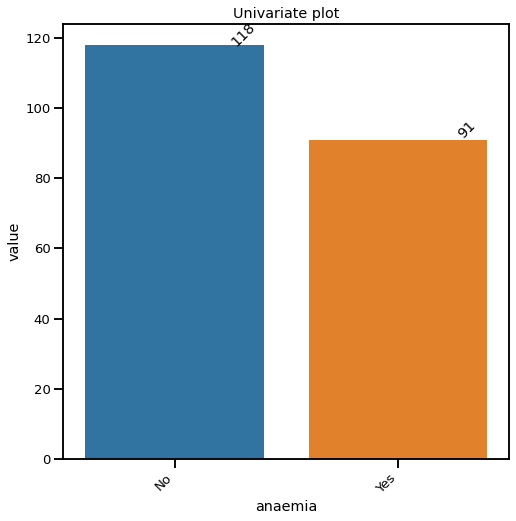


This is univariate analysis for ' diabetes ' 
      Count  Percentage
No     124       59.33
Yes     85       40.67


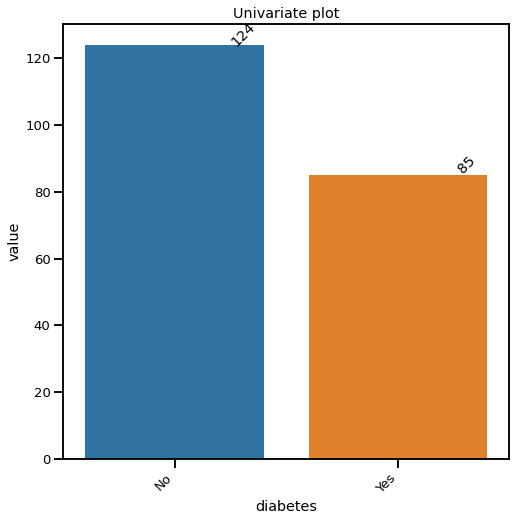


This is univariate analysis for ' high_blood_pressure ' 
      Count  Percentage
No     138       66.03
Yes     71       33.97


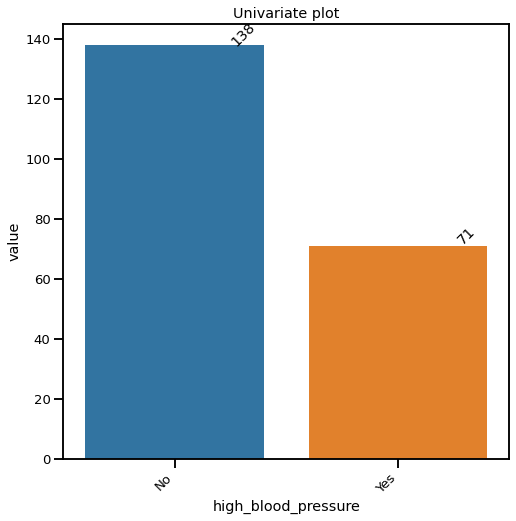


This is univariate analysis for ' sex ' 
         Count  Percentage
Male      130        62.2
Female     79        37.8


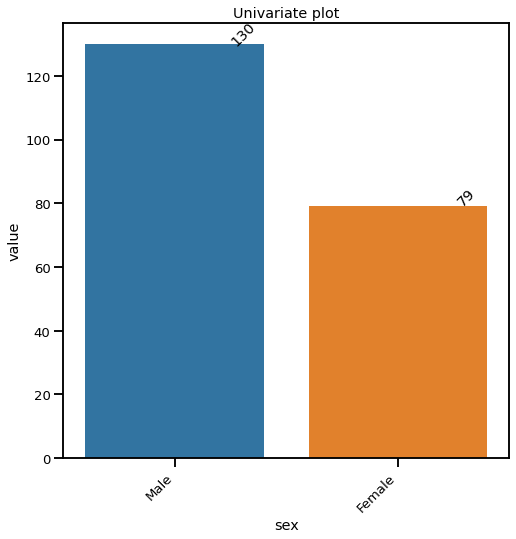


This is univariate analysis for ' smoking ' 
      Count  Percentage
No     143       68.42
Yes     66       31.58


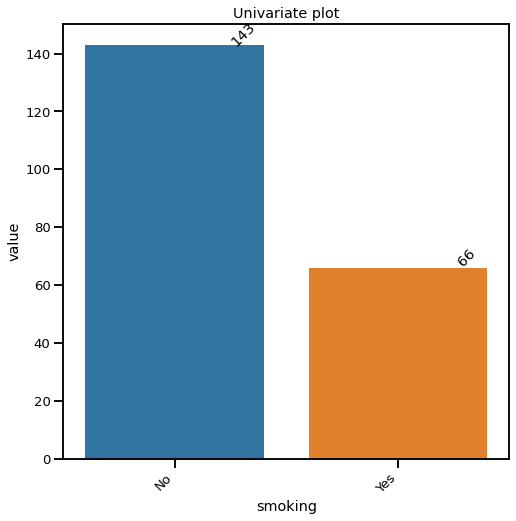


This is univariate analysis for ' DEATH_EVENT ' 
           Count  Percentage
Censored    136       65.07
Died         73       34.93


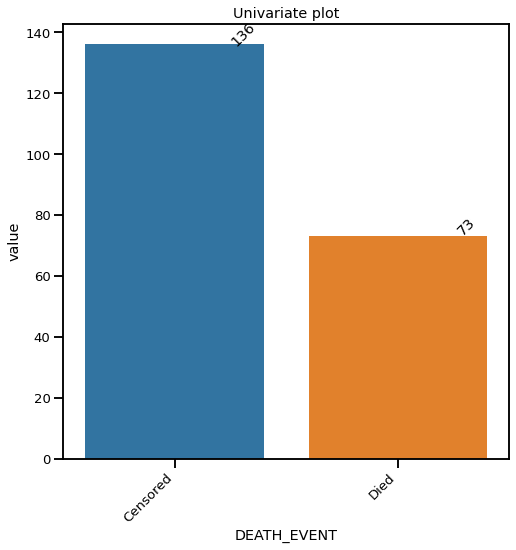

In [18]:
uni_categorical(df_exp, label='Y')

Most features are unbalanced.

Target feature 'DEATH_EVENT' have a high inbalance with most values being Censored.

##### Checking numerical features 

############### Univariate analysis - Numerical ###############**

 This is univariate analysis for ' age ' 
 count                          209.0
mean                        60.94099
std                        11.587332
min                             40.0
25%                             51.0
50%                             60.0
75%                             70.0
max                             90.0
variance                  134.266265
IQR                             19.0
range                           50.0
skewness                    0.319612
kurtosis                    -0.40617
mode        0    60.0
dtype: float64
Name: age, dtype: object


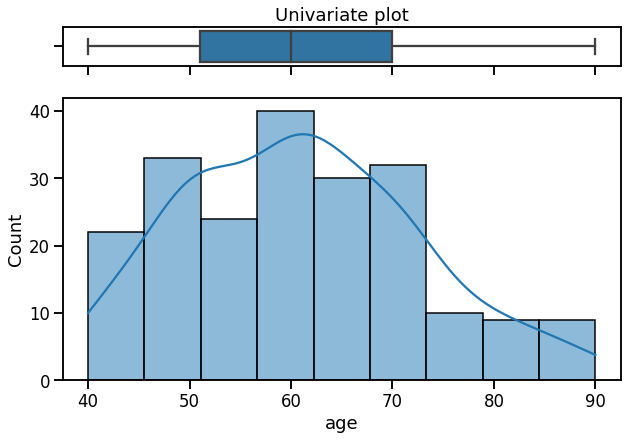

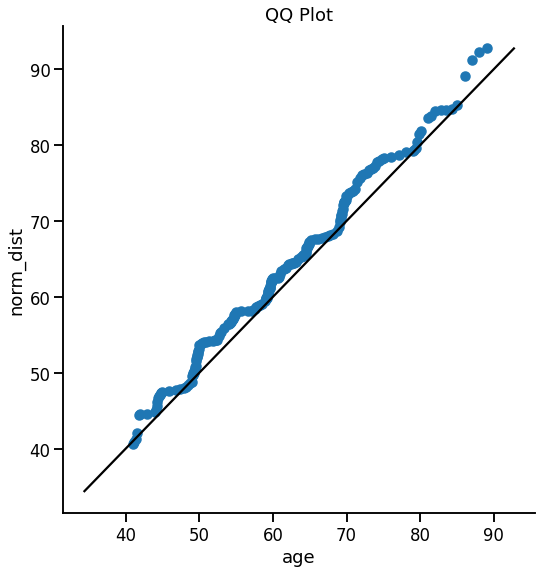

Kolmogorov's Statistics=1.000, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


_____________________________________________________________________________



 This is univariate analysis for ' creatinine_phosphokinase ' 
 count                       209.0
mean                   591.296651
std                    1072.79492
min                          23.0
25%                         109.0
50%                         235.0
75%                         582.0
max                        7861.0
variance           1150888.940421
IQR                         473.0
range                      7838.0
skewness                 4.453275
kurtosis                 23.34661
mode        0    582
dtype: int64
Name: creatinine_phosphokinase, dtype: object


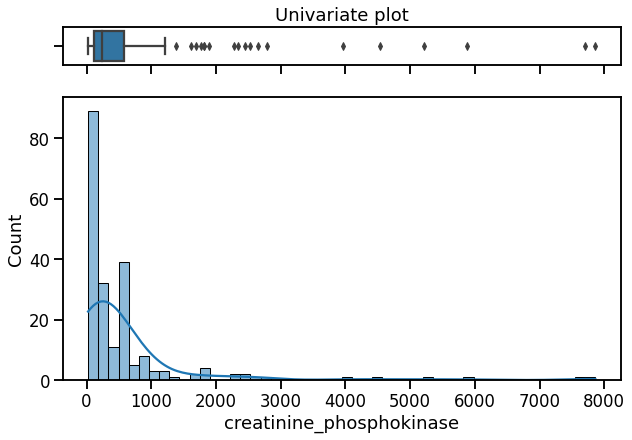

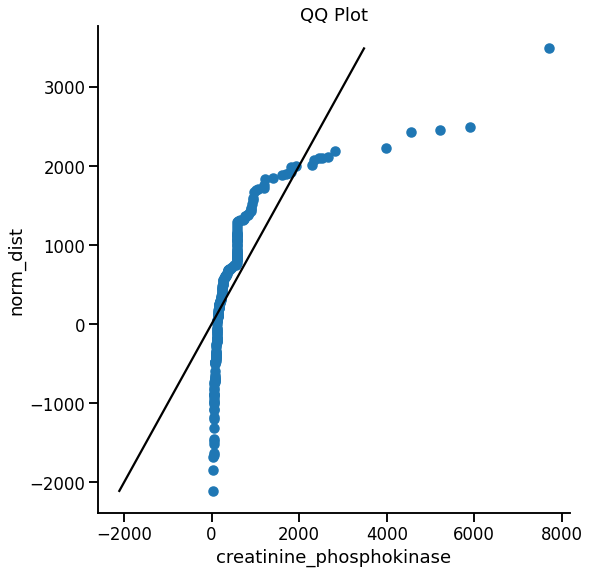

Kolmogorov's Statistics=1.000, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


_____________________________________________________________________________



 This is univariate analysis for ' ejection_fraction ' 
 count                      209.0
mean                   37.411483
std                      11.6678
min                         14.0
25%                         30.0
50%                         38.0
75%                         45.0
max                         70.0
variance               136.13756
IQR                         15.0
range                       56.0
skewness                0.426359
kurtosis               -0.184003
mode        0    35
dtype: int64
Name: ejection_fraction, dtype: object


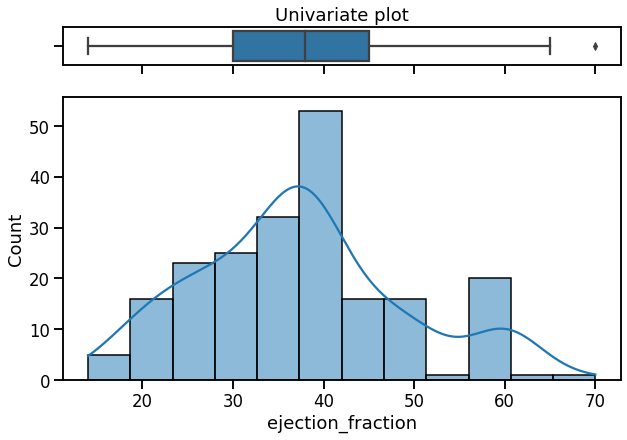

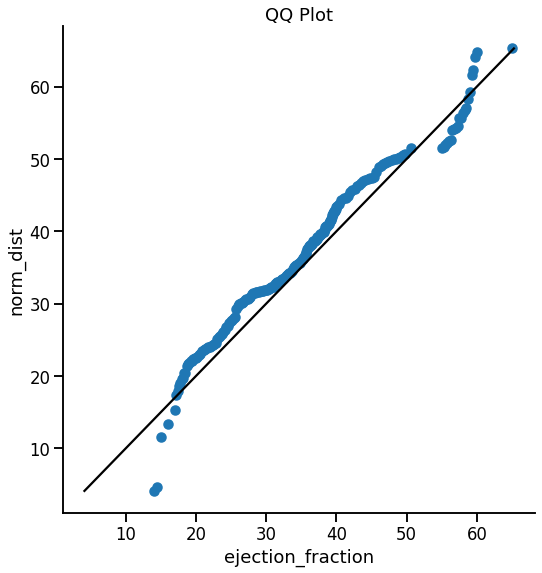

Kolmogorov's Statistics=1.000, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


_____________________________________________________________________________



 This is univariate analysis for ' platelets ' 
 count                               209.0
mean                         261030.83512
std                          84551.244327
min                               47000.0
25%                              216000.0
50%                             263358.03
75%                              304000.0
max                              621000.0
variance                7148912917.213915
IQR                               88000.0
range                            574000.0
skewness                           0.4383
kurtosis                         1.388921
mode        0    263358.03
dtype: float64
Name: platelets, dtype: object


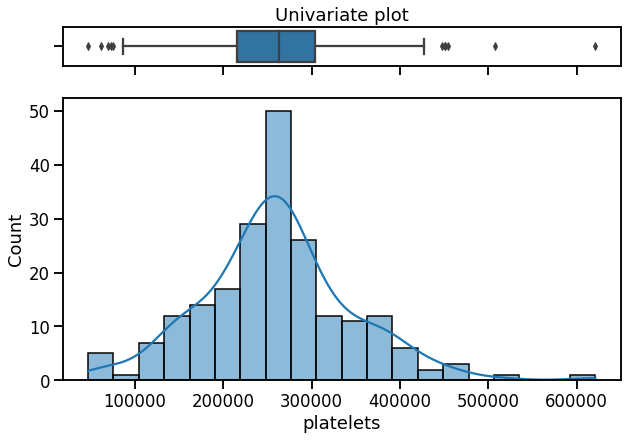

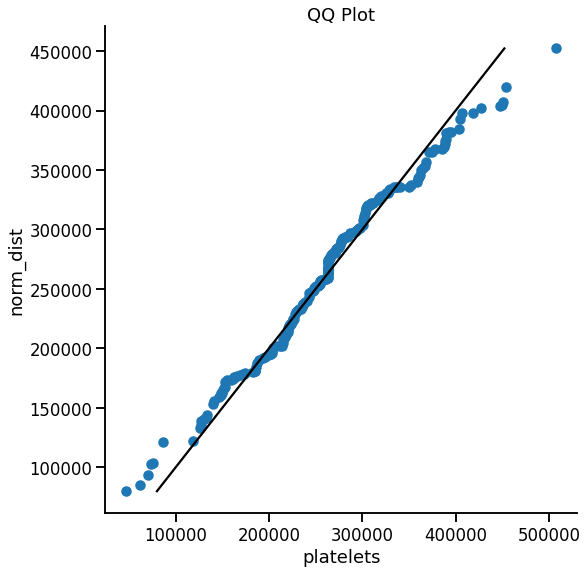

Kolmogorov's Statistics=1.000, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


_____________________________________________________________________________



 This is univariate analysis for ' serum_creatinine ' 
 count                         209.0
mean                       1.407081
std                        1.042411
min                             0.5
25%                             0.9
50%                             1.1
75%                             1.5
max                             9.4
variance                    1.08662
IQR                             0.6
range                           8.9
skewness                   4.818988
kurtosis                  30.613856
mode        0    1.0
dtype: float64
Name: serum_creatinine, dtype: object


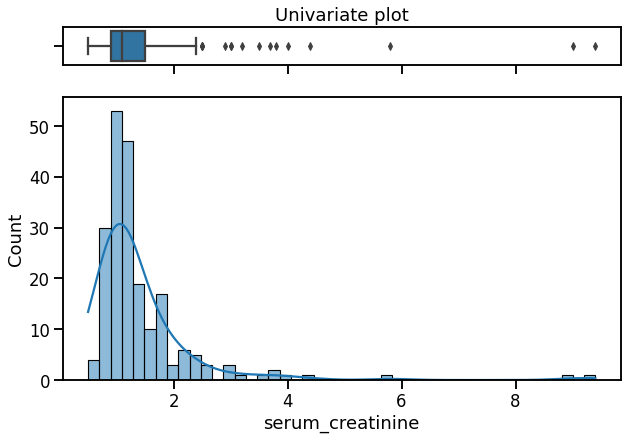

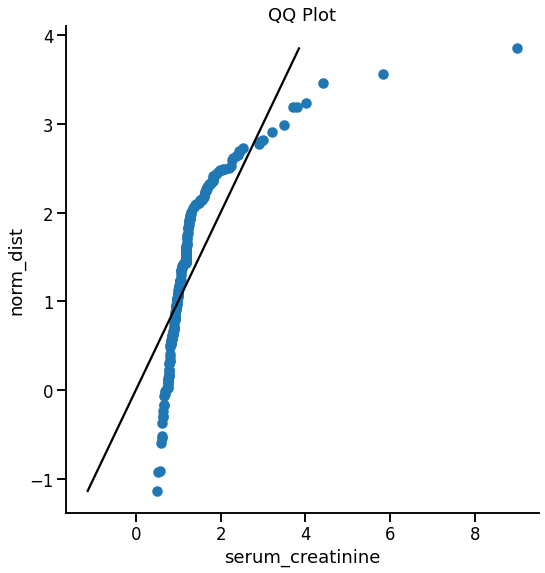

Kolmogorov's Statistics=0.739, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


_____________________________________________________________________________



 This is univariate analysis for ' serum_sodium ' 
 count                                209.0
mean                             136.38756
std                               4.403674
min                                  113.0
25%                                  134.0
50%                                  137.0
75%                                  140.0
max                                  148.0
variance                         19.392344
IQR                                    6.0
range                                 35.0
skewness                         -0.978869
kurtosis                          3.857175
mode        0    134
1    136
dtype: int64
Name: serum_sodium, dtype: object


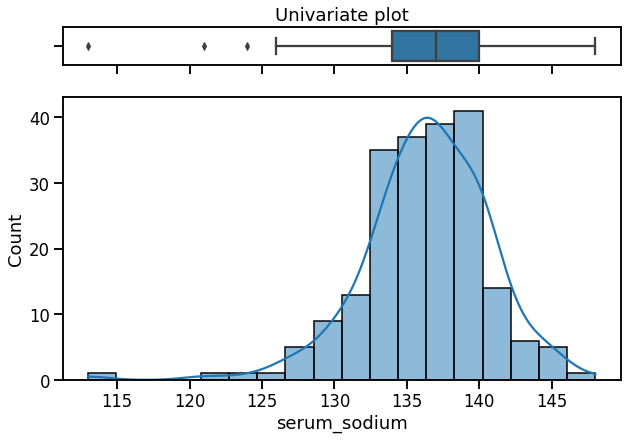

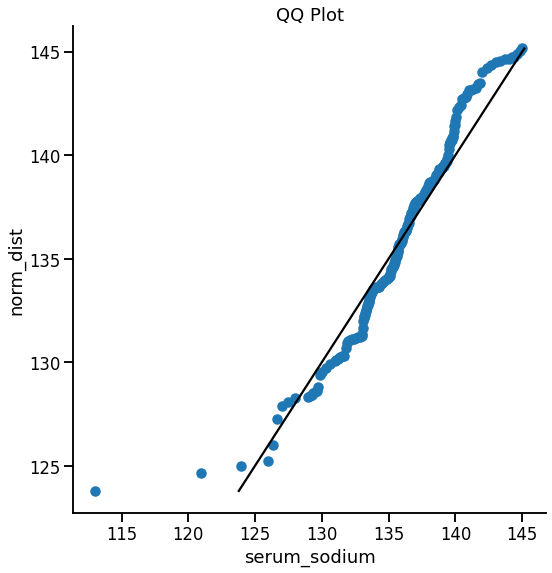

Kolmogorov's Statistics=1.000, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


_____________________________________________________________________________



 This is univariate analysis for ' time ' 
 count                                209.0
mean                            128.296651
std                              77.255558
min                                    4.0
25%                                   72.0
50%                                  115.0
75%                                  196.0
max                                  285.0
variance                       5968.421191
IQR                                  124.0
range                                281.0
skewness                          0.105028
kurtosis                         -1.223545
mode        0     10
1    186
dtype: int64
Name: time, dtype: object


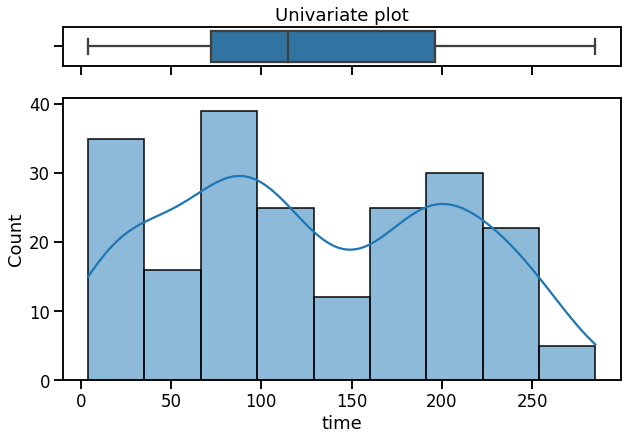

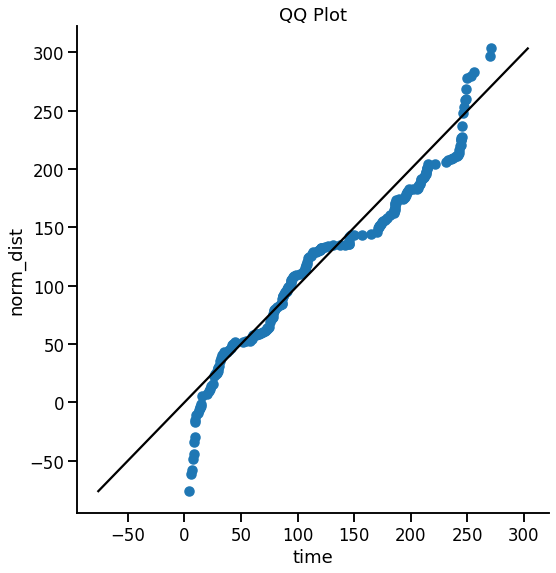

Kolmogorov's Statistics=1.000, p=0.000
Normality's test result: Sample does not look Gaussian (reject H0)


_____________________________________________________________________________




In [19]:
uni_numerical(df_exp)

None of the numeric features looks normal shaped or had its statistical test (Kolmogorov-Smirnov) pointing to a normal distribution. Platelets, serum creatinine phosphokinase and serum creatinine have a great number of outliers observations.

Development observation: 
    Pausing statistical analysis to gather business information about the features and its impact towards target (DEATH_EVENT) to better perform feature selection.